In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
from pandas.io.parsers import read_csv
from sklearn.utils import shuffle
from keras.models import model_from_json
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.layers import Conv2D, MaxPool2D, Flatten
from keras.optimizers import SGD
from matplotlib import pyplot as plt
import importlib
import random

Using TensorFlow backend.


In [2]:
def normlabel(y, reverse=False):
    """normalize / de-normalize label 
    
    Arguments:
        y {np.array} -- raw or normalized label
    
    Keyword Arguments:
        reverse {bool} -- normalize / de-normalize label (default: {False})
    """
    if reverse:
        return  y*48 + 48
    else:
        return (y - 48) / 48


In [3]:

def loadset(fname, test=False, cols=None):
    """Load datasets from CSV file
    
    Arguments:
        fname {str} -- filepath
    
    Keyword Arguments:
        test {bool} -- if file is test set (default: {False})
        cols {list} -- retain 'Image' and designated columns only (default: {None})
    
    Return:(X, y)
    """
    df = read_csv(fname)    # pixel value stored in 'Image' column
    df['Image'] = df['Image'].apply(lambda im: np.fromstring(im, sep=' '))

    if cols:
        df = df[list(cols) + ['Image']]

    print(df.count())       # summary
    df = df.dropna()        # holds rows with all keypoints only

    X = np.vstack(df['Image'].values) / 255.    # normalize grayscale in[0,1]
    X = X.astype(np.float32)

    if not test:
        y = df[df.columns[:-1]].values          # columns without 'image'
        y = normlabel(y, reverse=False)         # normalize coords in [0,1]
        X, y = shuffle(X, y, random_state=42)
        y = y.astype(np.float32)
    else:
        y = None

    return (X, y)

In [4]:

trainlib = 'training.csv'
testlib  = 'test.csv'

(X, y) = loadset(trainlib)

print()
print("X.shape == {}; X.min == {:.3f}; X.max == {:.3f}".format(X.shape, X.min(), X.max()))
print("y.shape == {}; y.min == {:.3f}; y.max == {:.3f}".format(y.shape, y.min(), y.max()))

left_eye_center_x            7039
left_eye_center_y            7039
right_eye_center_x           7036
right_eye_center_y           7036
left_eye_inner_corner_x      2271
left_eye_inner_corner_y      2271
left_eye_outer_corner_x      2267
left_eye_outer_corner_y      2267
right_eye_inner_corner_x     2268
right_eye_inner_corner_y     2268
right_eye_outer_corner_x     2268
right_eye_outer_corner_y     2268
left_eyebrow_inner_end_x     2270
left_eyebrow_inner_end_y     2270
left_eyebrow_outer_end_x     2225
left_eyebrow_outer_end_y     2225
right_eyebrow_inner_end_x    2270
right_eyebrow_inner_end_y    2270
right_eyebrow_outer_end_x    2236
right_eyebrow_outer_end_y    2236
nose_tip_x                   7049
nose_tip_y                   7049
mouth_left_corner_x          2269
mouth_left_corner_y          2269
mouth_right_corner_x         2270
mouth_right_corner_y         2270
mouth_center_top_lip_x       2275
mouth_center_top_lip_y       2275
mouth_center_bottom_lip_x    7016
mouth_center_b

In [5]:
def modellib(name='single', dim=9216):
    """keras NN model library
    
    Arguments:
        name {str} -- model name
            - 'single': 1-hidden-layer
        dim {int/tuple} -- input dimension (default: {9216})
    Return: compiled Keras model
    """
    model = Sequential()

    if name == 'single':
        model.add(Dense(100,input_dim=dim))    # FC1
        model.add(Activation('relu'))
        model.add(Dense(30))                    # FC2
        sgd = SGD(lr=0.01 ,momentum=0.9, nesterov=True)
        model.compile(loss='mean_squared_error',optimizer=sgd)
    
    if name == 'CNN':
        model.add(Conv2D(32, (3, 3), input_shape=dim))  # CONV1
        model.add(Activation('relu'))
        model.add(MaxPool2D(pool_size=(2, 2)))  # FC1

        model.add(Conv2D(64, (2, 2)))           # Conv2
        model.add(Activation('relu'))
        model.add(MaxPool2D(pool_size=(2, 2)))  # FC2

        model.add(Conv2D(128, (2, 2)))          # Conv3
        model.add(Activation('relu'))
        model.add(MaxPool2D(pool_size=(2, 2)))  # FC3

        model.add(Flatten())
        model.add(Dense(500))
        model.add(Activation('relu'))
        model.add(Dense(500))
        model.add(Activation('relu'))
        model.add(Dense(30))                    # 30 coords

        sgd = SGD(lr=0.01, momentum=0.9, nesterov=True)
        model.compile(loss='mean_squared_error', optimizer=sgd)

    return model

In [6]:
model = modellib(name='single')
model.summary()

hist = model.fit(X, y, epochs=100, validation_split=0.2)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               921700    
_________________________________________________________________
activation_1 (Activation)    (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 30)                3030      
Total params: 924,730
Trainable params: 924,730
Non-trainable params: 0
_________________________________________________________________
Train on 1712 samples, validate on 428 samples
Epoch 1/100
1712/1712 [==============================] - 1s 637us/step - loss: 0.0568 - val_loss: 0.0196
Epoch 2/100
1712/1712 [==============================] - 1s 533us/step - loss: 0.0139 - val_loss: 0.0112
Epoch 3/100
1712/1712 [==============================] - 1s 541us/step - loss: 0.0110 - val_loss: 0.0111
Epoch 4/100
1712/1712 [===============

1712/1712 [==============================] - 1s 495us/step - loss: 0.0028 - val_loss: 0.0039
Epoch 72/100
1712/1712 [==============================] - 1s 497us/step - loss: 0.0028 - val_loss: 0.0039
Epoch 73/100
1712/1712 [==============================] - 1s 474us/step - loss: 0.0028 - val_loss: 0.0040
Epoch 74/100
1712/1712 [==============================] - 1s 488us/step - loss: 0.0027 - val_loss: 0.0040
Epoch 75/100
1712/1712 [==============================] - 1s 662us/step - loss: 0.0027 - val_loss: 0.0038
Epoch 76/100
1712/1712 [==============================] - 1s 509us/step - loss: 0.0028 - val_loss: 0.0038
Epoch 77/100
1712/1712 [==============================] - 1s 580us/step - loss: 0.0026 - val_loss: 0.0039
Epoch 78/100
1712/1712 [==============================] - 1s 591us/step - loss: 0.0026 - val_loss: 0.0039
Epoch 79/100
1712/1712 [==============================] - 1s 574us/step - loss: 0.0027 - val_loss: 0.0038
Epoch 80/100
1712/1712 [==============================] - 1

In [7]:
trainlib = 'training.csv'
testlib  = 'test.csv'

xtest, _ = loadset(testlib, test=True)
ypred    = model.predict(xtest)

ImageId    1783
Image      1783
dtype: int64


In [8]:
def predplot(xtest, ypred, save=None, show=True):
    """plotting pred outcome
    
    Arguments:
        xtest {np.array} -- test img
        ypred {np.array} -- pred label
    
    Keyword Arguments:
        save {str} -- filename if to save (default: {None})
        show {bool} -- show plot (default: {True})
    """
    total = xtest.shape[0]
    start = random.randint(0, total-16)
    print('image',start,'to',start+16)

    fig = plt.figure(figsize=(12, 12))
    # fig.subplots_adjust(left=0, right=0.5, bottom=0, top=0.5, hspace=0.05, wspace=0.05)

    for i in range(start, start+16):
        x, y = xtest[i], ypred[i]
        img  = x.reshape(96, 96)
        axis = fig.add_subplot(4, 4, i-start+1, xticks=[], yticks=[])
        axis.imshow(img, cmap='gray')   # show image
        axis.scatter(normlabel(y[0::2], reverse=True),  # show lanmark
                     normlabel(y[1::2], reverse=True), marker='x', s=10)
    figure = plt.gcf()
    
    if save != None:    # deprecated
        figure.savefig(save, dpi=300)
        print(save, 'saved.')

    if show:
        plt.show()

('image', 23, 'to', 39)
('img/pred-single.png', 'saved.')


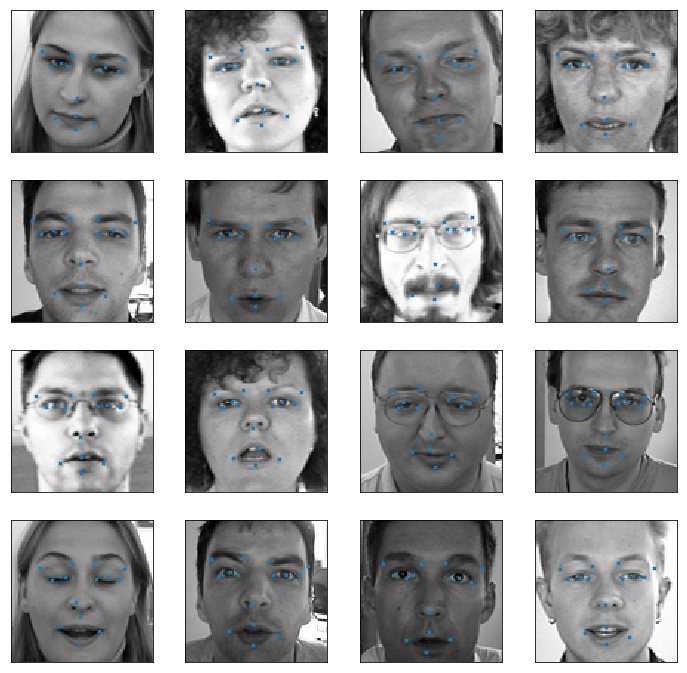

In [9]:
predplot(xtest, ypred, save='img/pred-single.png', show=True)

In [10]:
def loadset2d(fname, test=False, cols=None):
    (X, y) = loadset(fname, test=False, cols=None)
    X = X.reshape(-1, 96, 96, 1)
    return (X, y)

In [11]:

trainlib = 'training.csv'
testlib  = 'test.csv'

(X, y) = loadset2d(trainlib)

print()
print("X.shape == {}; X.min == {:.3f}; X.max == {:.3f}".format(X.shape, X.min(), X.max()))
print("y.shape == {}; y.min == {:.3f}; y.max == {:.3f}".format(y.shape, y.min(), y.max()))

left_eye_center_x            7039
left_eye_center_y            7039
right_eye_center_x           7036
right_eye_center_y           7036
left_eye_inner_corner_x      2271
left_eye_inner_corner_y      2271
left_eye_outer_corner_x      2267
left_eye_outer_corner_y      2267
right_eye_inner_corner_x     2268
right_eye_inner_corner_y     2268
right_eye_outer_corner_x     2268
right_eye_outer_corner_y     2268
left_eyebrow_inner_end_x     2270
left_eyebrow_inner_end_y     2270
left_eyebrow_outer_end_x     2225
left_eyebrow_outer_end_y     2225
right_eyebrow_inner_end_x    2270
right_eyebrow_inner_end_y    2270
right_eyebrow_outer_end_x    2236
right_eyebrow_outer_end_y    2236
nose_tip_x                   7049
nose_tip_y                   7049
mouth_left_corner_x          2269
mouth_left_corner_y          2269
mouth_right_corner_x         2270
mouth_right_corner_y         2270
mouth_center_top_lip_x       2275
mouth_center_top_lip_y       2275
mouth_center_bottom_lip_x    7016
mouth_center_b

In [12]:
def modellib(name='single', dim=9216):
    """keras NN model library
    
    Arguments:
        name {str} -- model name
            - 'single': 1-hidden-layer
        dim {int/tuple} -- input dimension (default: {9216})
    Return: compiled Keras model
    """
    model = Sequential()

    if name == 'single':
        model.add(Dense(100,input_dim=dim))    # FC1
        model.add(Activation('relu'))
        model.add(Dense(30))                    # FC2
        sgd = SGD(lr=0.01 ,momentum=0.9, nesterov=True)
        model.compile(loss='mean_squared_error',optimizer=sgd)
    
    if name == 'CNN':
        model.add(Conv2D(32, (3, 3), input_shape=dim))  # CONV1
        model.add(Activation('relu'))
        model.add(MaxPool2D(pool_size=(2, 2)))  # FC1

        model.add(Conv2D(64, (2, 2)))           # Conv2
        model.add(Activation('relu'))
        model.add(MaxPool2D(pool_size=(2, 2)))  # FC2

        model.add(Conv2D(128, (2, 2)))          # Conv3
        model.add(Activation('relu'))
        model.add(MaxPool2D(pool_size=(2, 2)))  # FC3

        model.add(Flatten())
        model.add(Dense(500))
        model.add(Activation('relu'))
        model.add(Dense(500))
        model.add(Activation('relu'))
        model.add(Dense(30))                    # 30 coords

        sgd = SGD(lr=0.01, momentum=0.9, nesterov=True)
        model.compile(loss='mean_squared_error', optimizer=sgd)

    return model

In [13]:
modelCNN = modellib(name='CNN', dim=(96, 96, 1))
modelCNN.summary()

histCNN = modelCNN.fit(X, y, epochs=100, validation_split=0.2)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 94, 94, 32)        320       
_________________________________________________________________
activation_2 (Activation)    (None, 94, 94, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 47, 47, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 46, 46, 64)        8256      
_________________________________________________________________
activation_3 (Activation)    (None, 46, 46, 64)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 23, 23, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 22, 22, 128)       32896     
__________

1712/1712 [==============================] - 36s 21ms/step - loss: 0.0039 - val_loss: 0.0040
Epoch 57/100
1712/1712 [==============================] - 35s 20ms/step - loss: 0.0039 - val_loss: 0.0040
Epoch 58/100
1712/1712 [==============================] - 34s 20ms/step - loss: 0.0039 - val_loss: 0.0040
Epoch 59/100
1712/1712 [==============================] - 34s 20ms/step - loss: 0.0039 - val_loss: 0.0039
Epoch 60/100
1712/1712 [==============================] - 35s 21ms/step - loss: 0.0039 - val_loss: 0.0039
Epoch 61/100
1712/1712 [==============================] - 34s 20ms/step - loss: 0.0039 - val_loss: 0.0039
Epoch 62/100
1712/1712 [==============================] - 34s 20ms/step - loss: 0.0038 - val_loss: 0.0039
Epoch 63/100
1712/1712 [==============================] - 39s 23ms/step - loss: 0.0038 - val_loss: 0.0039
Epoch 64/100
1712/1712 [==============================] - 34s 20ms/step - loss: 0.0038 - val_loss: 0.0038
Epoch 65/100
1712/1712 [==============================] - 3

In [15]:
def histplot(hist, save=None, show=True):
    """plotting loss function
    
    Arguments:
        hist {keras.callbacks.History} -- hist = model.fit
    
    Keyword Arguments:
        save {str} -- filename if to save (default: {None})
        show {bool} -- show plot (default: {True})
    """
    plt.figure()
    plt.plot(hist.history['loss'], linewidth=2, label='train')
    plt.plot(hist.history['val_loss'], linewidth=2,label='valid set')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    # plt.ylim(1e-3, 1e-2)
    plt.yscale('log')
    plt.grid()               # show metrics(0, 20, 40...)
    plt.legend(loc='best')
    figure = plt.gcf()

    if save != None:
        figure.savefig(save, dpi=300)
        print(save, 'saved.')

    if show:
        plt.show()

def histplotdiff(hist1, hist2, save=None, show=True):
    """plotting loss function
    
    Arguments:
        hist {keras.callbacks.History} -- hist = model.fit
    
    Keyword Arguments:
        save {str} -- filename if to save (default: {None})
        show {bool} -- show plot (default: {True})
    """
    plt.figure()
    plt.plot(hist1.history['loss'], linewidth=2, label='train1')
    plt.plot(hist1.history['val_loss'], linewidth=2,label='valid1')
    plt.plot(hist2.history['loss'], linewidth=2, label='train2')
    plt.plot(hist2.history['val_loss'], linewidth=2,label='valid2')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    # plt.ylim(1e-3, 1e-2)
    plt.yscale('log')
    plt.grid()               # show metrics(0, 20, 40...)
    plt.legend(loc='best')
    figure = plt.gcf()

    if save != None:
        figure.savefig(save, dpi=300)
        print(save, 'saved.')

    if show:
        plt.show()

('img/CNN-test.png', 'saved.')


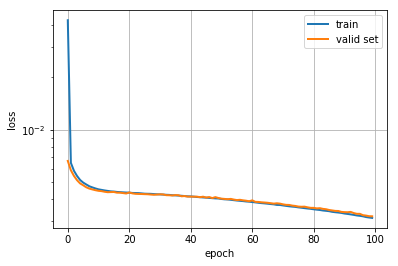

In [16]:
histplot(histCNN, save='img/CNN-test.png', show=True)

In [17]:


# prediction

trainlib = 'training.csv'
testlib  = 'test.csv'

xtest, _ = loadset2d(testlib, test=True)
ypred = modelCNN.predict(xtest)



ImageId    1783
Image      1783
dtype: int64


('image', 500, 'to', 516)
('img/pred-CNN.png', 'saved.')


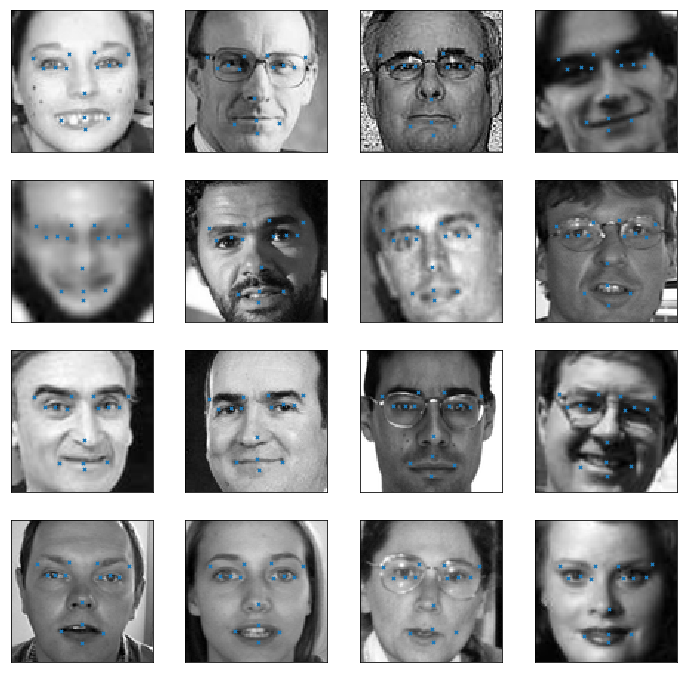

In [18]:
predplot(xtest, ypred, save='img/pred-CNN.png', show=True)

In [19]:
trainlib = 'training.csv'
testlib  = 'test.csv'

xtest,    _= loadset(testlib, test=True)
xtest2d, _ = loadset2d(testlib, test=True)
ypred      = model.predict(xtest)
ypredCNN   = modelCNN.predict(xtest2d)

ImageId    1783
Image      1783
dtype: int64
ImageId    1783
Image      1783
dtype: int64


('img/hist-compare.png', 'saved.')


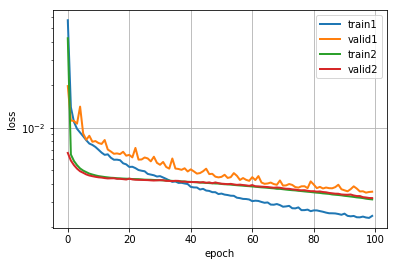

In [20]:
histplotdiff(hist, histCNN, save='img/hist-compare.png', show=True)



In [22]:
def predplotdiff(xtest, ypred1, ypred2, save=None, show=True):
    """compare pred outcome
    
    Arguments:
        xtest {np.array} -- test img
        ypred {np.array} -- pred label
    
    Keyword Arguments:
        save {str} -- filename if to save (default: {None})
        show {bool} -- show plot (default: {True})
    """
    total = xtest.shape[0]
    start = random.randint(0, total-16)
    print('image',start,'to',start+4)

    # fig.subplots_adjust(left=0, right=0.5, bottom=0, top=0.5, hspace=0.05, wspace=0.05)

    fig = plt.figure(figsize=(12, 6))
    for n,i in enumerate(range(start, start+4)):
        x, y1, y2 = xtest[i], ypred1[i], ypred2[i]
        img  = x.reshape(96, 96)
        
        axis1 = fig.add_subplot(2, 4, 2*n+1, xticks=[], yticks=[])
        axis1.imshow(img, cmap='gray')   # show image
        axis1.scatter(normlabel(y1[0::2], reverse=True),  # show lanmark
                      normlabel(y1[1::2], reverse=True), color='b', marker='x', s=10, label='pred1')
        axis1.legend(loc='best')
        
        axis2 = fig.add_subplot(2, 4, 2*n+2, xticks=[], yticks=[])
        axis2.imshow(img, cmap='gray')   # show image
        axis2.scatter(normlabel(y2[0::2], reverse=True),  # show lanmark
                      normlabel(y2[1::2], reverse=True), color='r', marker='x', s=10, label='pred2')
        axis2.legend(loc='best')
                
    figure = plt.gcf()
    
    if save != None:    # deprecated
        figure.savefig(save, dpi=300)
        print(save, 'saved.')

    if show:
        plt.show()

('image', 40, 'to', 44)
('img/pred-compare.png', 'saved.')


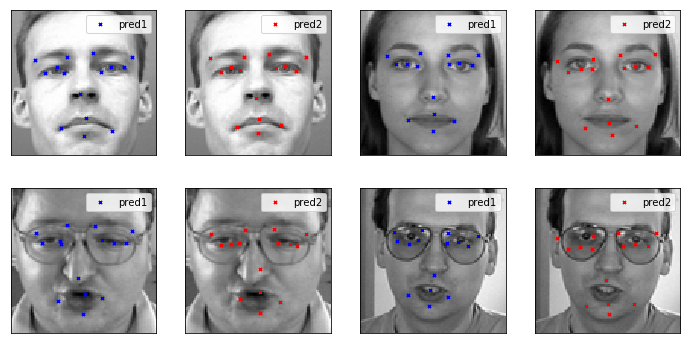

In [24]:
predplotdiff(xtest, ypred, ypredCNN, save='img/pred-compare.png', show=True)


('image', 827, 'to', 831)


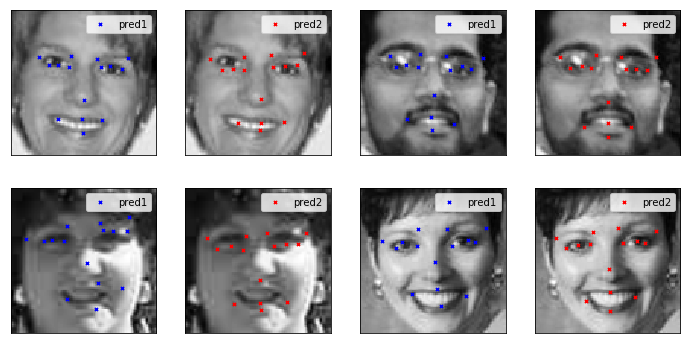

In [25]:
predplotdiff(xtest, ypred, ypredCNN, show=True)


('image', 544, 'to', 548)


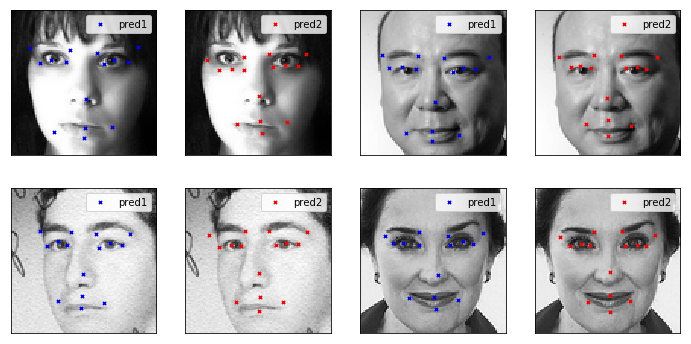

In [26]:
predplotdiff(xtest, ypred, ypredCNN, show=True)


('image', 1036, 'to', 1040)


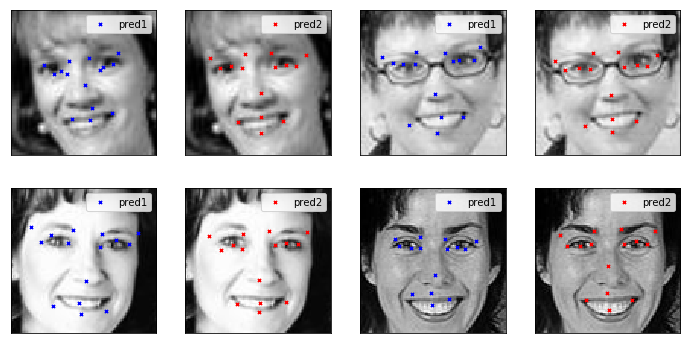

In [27]:
predplotdiff(xtest, ypred, ypredCNN, show=True)


('image', 114, 'to', 118)


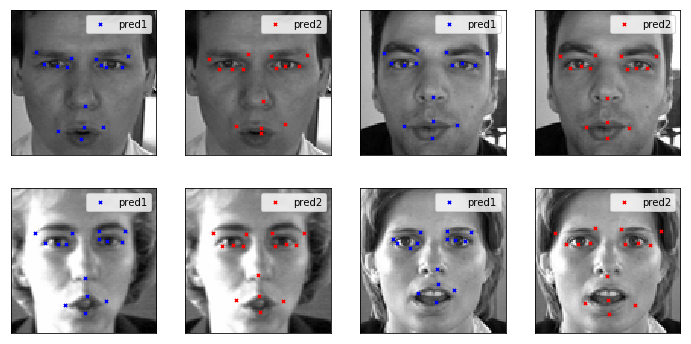

In [28]:
predplotdiff(xtest, ypred, ypredCNN, show=True)


('image', 1619, 'to', 1623)


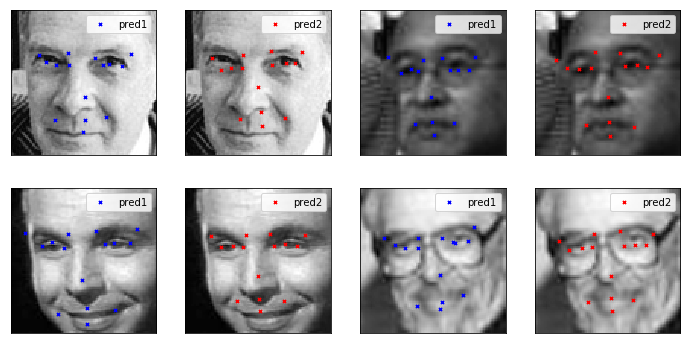

In [29]:
predplotdiff(xtest, ypred, ypredCNN, show=True)
